In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import flg_yolo
import flg_diagnostics

fast_mode = False
if fls.is_submission:
    fast_mode = False

MainProcess


In [19]:
data = fls.dill_load('C:\\Users\\jeroe\\Downloads\\Baseline_0_d7f7501f_.81 _f.pickle')
ref_data = data.test_data
inferred_data = data.inferred_test_data
len(ref_data)

350

True positives: 136 out of 300
False negatives - seen but not selected: 96 out of 300
False negatives - not seen: 68 out of 300
False positives: 30 out of 50


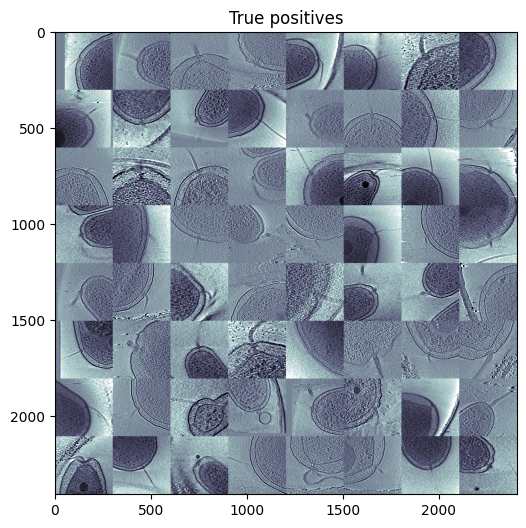

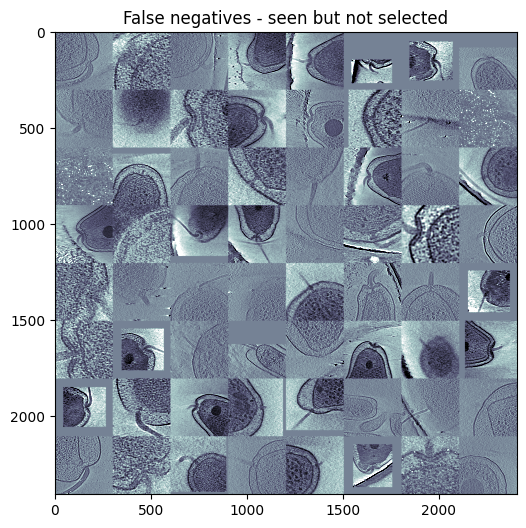

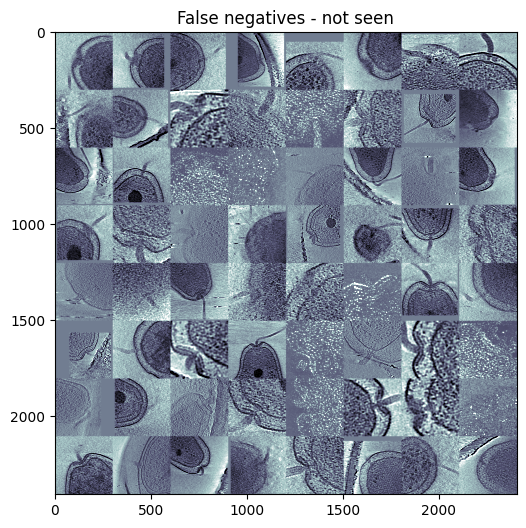

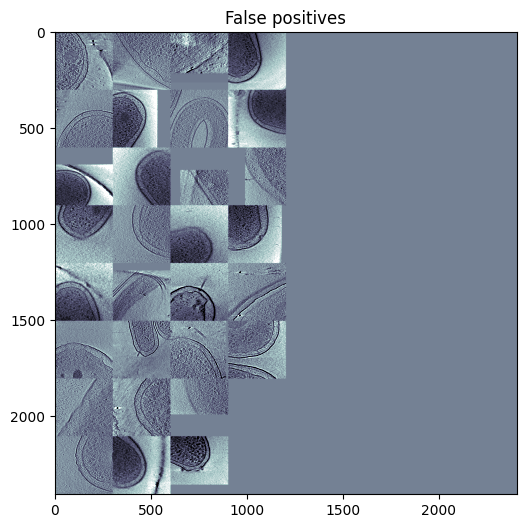

In [33]:
importlib.reload(flg_diagnostics)
flg_diagnostics.show_tf_pn(inferred_data, ref_data)